# Sistemas Nebulosos

## Atividade Prática I - Agrupamento Nebuloso

***
### Felipe Bartelt de Assis Pessoa - 2016026841
### Wanderson da Silva Maciel Filho - 2017002660

In [84]:
from PIL import Image
from scipy.io import loadmat
from plotly.subplots import make_subplots
import numpy as np
import plotly.graph_objects as go
import pandas as pd
import os
import sys
print('Python version: '+sys.version)
print('Numpy version: '+np.__version__, '\nPlotly version: '+__import__('plotly').__version__)

Python version: 3.9.7 (default, Oct 10 2021, 15:13:22) 
[GCC 11.1.0]
Numpy version: 1.21.2 
Plotly version: 5.3.1


# Fuzzy C-Means

## Considerações para a inicialização aleatória

Para a implementação do Fuzzy C-means, é necessário inicializar uma matriz de pertinência $U$ aleatória com valores $x\in[0,1]$, tal que a soma de todos esses valores seja igual a $1$. Assim, decidiu-se utilizar a distribuição de Dirichlet, com $\alpha = \mathbb{1}$ de dimensão igual ao número de *clusters* $k$. Por meio da função intrínseca ao `numpy`, pode-se então gerar facilmente uma matriz $U\in\mathbb{M}_{n\times k}$, onde $n$ é o número de amostras.

Abaixo segue uma demonstração da geração de uma matriz aleatória por meio da distribuição de Dirichlet. Gera-se uma matriz $5\times4$, cuja soma dos elementos das linhas é igual a $1$:

In [4]:
dirichlet = np.random.default_rng().dirichlet(np.ones(4), 5) # 5x4 matrix
print(dirichlet)
print('\nSoma dos elementos das linhas:', np.sum(dirichlet, axis=1))

[[0.32369001 0.14439422 0.49006397 0.0418518 ]
 [0.09154366 0.39947776 0.43643843 0.07254015]
 [0.28673533 0.21738599 0.40140622 0.09447246]
 [0.04041216 0.46463545 0.0974056  0.39754679]
 [0.04984667 0.36825499 0.57371372 0.00818462]]

Soma dos elementos das linhas: [1. 1. 1. 1. 1.]


## Implementação

A função `fuzzy_cmeans` tem como parâmetros `X`, a matriz de amostras $X\in\mathbb{M}_{n\times m}$, cujas $n$ linhas representam cada amostra (observação) e as $m$ colunas representam as *features* para cada amostra; o número de centros (*clusters*) `k`; o expoente de peso `weight` (tomado em Jang and Sun [1] como $m$), com valor *default* $2$, uma vez que é o mais comum; a tolerância `tol`, critério de parada do algoritmo, caso a função de custo $J\le \text{tol}$, o algoritmo encerra a execução, esse parâmetro é tomado como $10^{-3}$ como *defautlt*.

A função então inicializa uma matriz de pertinência aleatória `membership_mat`, de tamanho $n \times k$, por meio da distribuição de Dirichlet, além de definir o custo atual $J = \text{tol} + 1$. Após, inicia-se um *while loop* enquanto a função de custo $J$ é maior que a tolerância `tol`. 

> Para facilitar a formulação de equações matemáticas, tomar-se-á as seguintes equivalências de notação:
> 
> `membership_mat` = $U$, `J`=$J$, `J_old`=$J_\text{old}$, `c` = $C$, `D` = $D$, `weight`=$w$, `sum_div` = $\Sigma$
>  
> Também, far-se-á necessário a definição dos operadores de Hadamard:
> 
> $A\circ B = (A)_{ij}\cdot(B)_{ij}$, a multiplicação matricial *element-wise*
> 
> $A\text{\O} B = \frac{(A)_{ij}}{(B)_{ij}}$, a divisão matricial *element-wise*
> 
> $A^{\circ r} = (A)_{ij}^{r}$, a potência matricial *element-wise*



Dentro do *while loop*, toma-se $U = U^{\circ w}$, uma vez que todas as operações são realizadas sobre os elementos da matriz elevados ao expoente de peso. Salva-se o valor anterior da função de custo em uma variável $J_\text{old}$, para que seja possível finalizar a execução do algoritmo caso a diferença entre $J$ e $J_\text{old}$ seja inferior a $\text{tol}^2$, parâmetro definido arbitrariamente. 

Então, calcula-se a matriz de centros $C$ por meio de uma multiplicação matricial e uma divisão vetorial, possível devido ao *broadcasting* da biblioteca `numpy`, ou seja, $\ C = \mathcal{C}\text{\O}\mathcal{U}$, onde $\ \mathcal{C} = U^TX\in\mathbb{M}_{k\times m}$, $\ \mathcal{U}\in\mathbb{M}_{k\times1}$, sendo $\mathcal{U}$ um vetor coluna resultante da soma dos elementos das linhas de $U$, ou seja $\mathcal{U}_{j} = \sum_{i=1}^{n}U_{ij}$, dessa forma, devido ao funcionamento do `numpy`, a divisão de Hadamard efetivamente divide cada **linha** de $\mathcal{C}$ pelo elemento da **linha** correspondente de $\mathcal{U}$. Dessa forma, implementa-se de forma otimizada e concisa, para uma matriz $X$ de tamanho qualquer, a operação definida em [1]:
$$
c_i =\frac{\sum_{j=1}^{n}u_{ij}^m\mathbb{x}_j}{\sum_{j=1}^{n}u_{ij}^m}
$$

Para o cálculo da função de custo $J$ e matriz de pertinência $U$, definiu-se uma matriz de distâncias $D\in\mathbb{M}_{k\times n}$, de forma a tornar o algoritmo conciso. Para a definição dessa matriz, novamente o funcionamento do *broadcasting* do `numpy` é levado em consideração. Gera-se uma matriz tridimensional $\mathcal{D}\in\mathbb{M}_{k\times n\times m}$, que contém em sua primeira dimensão $k$ matrizes, onde a $k$-ésima matriz contém os vetores de distância entre o centro do k-ésimo *cluster* $c_k$ e **cada um** dos pontos de $X$, de forma que os elementos $\mathcal{D}_{kn}$ são os vetores de distância entre o centro do k-ésimo *cluster* $c_k$ e o ponto $x_n$. Dessa forma, ao se tomar a norma euclidiana com relação à terceira dimensão de $\mathcal{D}$, efetivamente, calcula-se a norma das distâncias entre cada cluster $k$ e cada ponto $x_i\in X$, ou seja, tem-se a matriz $D$ com a forma

$$
D = \begin{bmatrix} d_{c_1x_1}&d_{c_1x_2}&\dots& d_{c_1x_n}\\ 
    d_{c_2x_1}&d_{c_2x_2}&\dots&d_{c_2x_n}\\
    \vdots & \vdots & \ddots&\vdots\\
     d_{c_kx_1}&d_{c_kx_2}&\dots &d_{c_kx_n}\\

\end{bmatrix}
$$

Definida a matriz $D$, é possível o custo atual por $J = \sum_{i=1}^{n}\sum_{j=1}^{k} (U^T\circ D^{\circ 2})_{ij}$ e então fazer o comparativo entre o custo atual e o anterior, de forma a interromper o processo caso a melhoria tenha sido baixa.

Para calcular a nova matriz de pertinência $U$ com base nos centros $C$ calculados, utiliza-se novamente o *broadcasting* do `numpy` unido da divisão de Hadamard. Primeiro define-se uma matriz $\Sigma\in\mathbb{M}_{k\times n }$, onde $\Sigma_{il} = \sum_{j=1}^{k} (\mathfrak{D}\text{\O}D)_{ijl}$, onde $\mathfrak{D}\in\mathbb{M}_{k\times 1\times n}$ é a transformação da matriz de distâncias $D$ em uma matriz tridimensional, de tal forma que o resultado de $\mathfrak{D}\text{\O}D\in\mathbb{M}_{k\times k\times n}$ representa o resultado de cada linha da matriz $D$ dividida por cada linha de $D$, ou seja, a i-ésima matriz pertencente ao resultado dessa operação contém o resultado da divisão de **cada** linha de $D$ dividida pela i-ésima linha de $D$, de forma que, ao tomar a soma na segunda dimensão da matriz resultante, tem-se a matriz $\Sigma$. Por meio dessa matriz, é possível calcular a matriz de pertinência pela relação 
$$ 
U = \left(1\ \text{\O}\ \left(\Sigma^{\circ \left(\frac{2}{w-1}\right)}\right)\right)^T\in\mathbb{M}_{n\times k}
$$ 
Ou seja, criou-se um equivalente matricial para a seguinte relação fornecida em [1]:
$$
u_{ij}=\frac{1}{\sum_{k=1}^{c}\left(\frac{d_{ij}}{d_{kj}}\right)^{2/(m-1)}}
$$

Então quando o *while loop* termina, retorna-se a matriz $C$ e $U$ calculadas.

In [2]:
def fuzzy_cmeans(X, k, weight=2, tol=1e-3):
    n, _ = X.shape # n x m
    J = tol + 1
    membership_mat = np.random.default_rng().dirichlet(np.ones(k), n) # generates n x k matrix

    while J > tol:
        membership_mat = membership_mat ** weight
        J_old = J
        c = (membership_mat.T @ X) / np.sum(membership_mat, axis=0)[:, None] # k x m
        D = np.linalg.norm(c[:, None, :] - X, axis=2) # k x n
        J = np.sum(membership_mat.T * (D ** 2))

        if np.abs(J - J_old) < tol**2:
            print('Small improvement since last iteration')
            break
        
        sum_div = np.sum(D[:, None] / D, axis=1)
        membership_mat = (1 / (sum_div ** (2 / (weight - 1)))).T

    return c, membership_mat

# Validação do Fuzzy C-Means

Utilizando-se a base de dados fornecida `fcm_dataset.mat`, calculou-se 4 *clusters* para seu agrupamento por meio da função `fuzzy_cmeans` definida anteriormente. Os valores dos centros dos *clusters* calculados são mostrados abaixo

In [38]:
X = loadmat('fcm_dataset.mat')['x']
c, u = fuzzy_cmeans(X, 4)
print('clusters: ', c)

Small improvement since last iteration
clusters:  [[4.0087831  5.01067181]
 [3.00812924 3.49209297]
 [3.49543398 4.48892342]
 [2.49387582 3.98970115]]


Plotando-se os dados fornecidos junto dos centros calculados, pode-se confirmar que a implementação foi bem sucedida, uma vez que os centros calculados estão, visualmente, centralizados com os grupos de dados visíveis. Também, é possível confirmar que o método *fuzzy* de agrupamento não encontra nenhum empecilho ao calcular centros para uma base de dados onde se é visível a existência de um número fixo de *clusters*

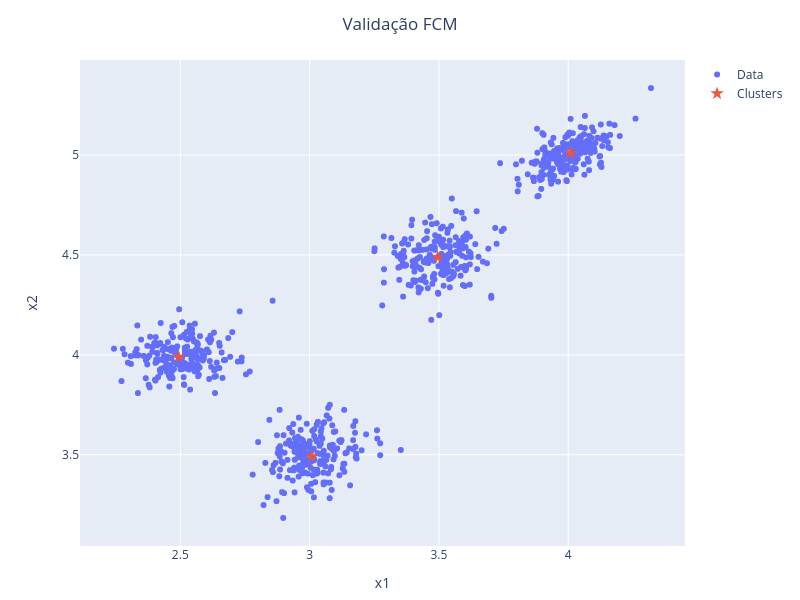

In [39]:
fig = go.Figure(go.Scatter(x=X[:, 0].flatten(), y=X[:, 1].flatten(), mode='markers', name='Data'))
fig.add_trace(go.Scatter(x=c[:, 0].flatten(), y=c[:, 1].flatten(), mode='markers', marker={'size':10, 'symbol':'star'}, name='Clusters'))
fig.update_layout(xaxis_title = 'x1', yaxis_title = 'x2', margin={'b':20, 't':60}, title='Validação FCM', title_x=0.5)
fig.show(renderer = 'png', width = 800, height = 600)

# Segmentação de Imagens por Região

Primeiramente, copiou-se as funções fornecidas para que fosse possível trabalhar com as imagens:

In [3]:
def photo_open(filename, rescale=1):
    photo = Image.open(filename)
    photo = photo.convert('RGB')
    photo =photo.resize( ( int(photo.size[0]/rescale), int(photo.size[1]/rescale) ), Image.ANTIALIAS)
    return photo

def pick_pixels(photo):
    n , m = photo.size
    ibagem = []
    pixels = photo.load()
    for i in range(n):
        for j in range(m):
            ibagem.append(list(pixels[i,j]) )
    return pd.DataFrame(ibagem)

def coloring(photo, labels, centers, rescale=1):
    n, m = photo.size
    pixels = photo.load()
    for i in range(n):
        for j in range(m):
            numb = [int(number) for number in centers[labels[i*m + j]] ] 
            pixels[i,j]= tuple(numb)
    photo = photo.resize( (int( photo.size[0]*rescale), int(photo.size[1]*rescale)), Image.ANTIALIAS)
    return photo

Em seguida, implementou-se a função `image_segmentation` que recebe como parâmetros: `k` uma lista com cada número de *clusters* a ser utilizado para cada imagem ou um valor único de *clusters* para ser utilizado para todas as imagens; e o parâmetro opcional `base_path` que é o caminho para o local onde estão armazenadas as imagens, que devem estar em uma pasta separada, uma vez que o código percorre o caminho especificado fazendo a segmentação de todos os arquivos nele encontrado, tem-se como *default* `./ImagensTeste`.

A função então faz a segmentação de cada imagem encontrada e plota todas lado a lado com a imagem original. A função não "plota" efetivamente, mas retorna um objeto `plotly.Figure`, que então deve ser plotado manualmente.

In [78]:
def image_segmentation(k, base_path = './ImagensTeste'):
    file_list = []

    for filename in os.listdir(base_path):
        file_list.append(filename)

    file_list.sort()

    if not isinstance(k, list):
        k = k * np.ones(len(file_list)).astype(int)
    elif len(k) != len(file_list):
        print(f'k must have lenght{len(file_list)}')
    #names = [pat+"%.3d" % i for i in range(start_num, end_num+1)]
    seg = [f'Segmentation (k={c})' for c in k]
    titles = [None]*(len(file_list)+len(seg))
    titles[::2] = [os.path.splitext(name)[0] for name in file_list]
    titles[1::2] = seg
    fig = make_subplots(rows=len(file_list),cols=2, subplot_titles=titles)

    for i, filename in enumerate(file_list):
        original = photo_open(os.path.join(base_path, filename))
        pixels = pick_pixels(original).to_numpy()
        centers, U = fuzzy_cmeans(pixels, k[i])
        labels = np.argmax(U, axis=1)
        segmented = coloring(original.copy(), labels, centers)
        
        fig.add_trace(go.Image(z=original), i+1, 1)
        fig.add_trace(go.Image(z=segmented), i+1, 2)

    return fig

Por meio da visualização das imagens e algumas tentativas para tentar agrupar o máximo de cores distintas, definiu-se os números de *clusters* $[5,5,5,6,6,4,5,8,8,7,4]$ para as imagens em ordem alfabética.

O resultado das segmentações pode ser visto abaixo. Nota-se que, apesar de ao olho humano aparentar existir alguns grupos de cores, o algoritmo "enxerga" grupos de forma diferente. Por exemplo, na primeira imagem, percebe-se que o algoritmo, ao invés de considerar um tom amarelo como um novo *cluster*, tende a separar tons de verde e vermelho, visto que são as cores mais presentes na imagem. Isso também ocore para a segunda imagem, para a qual a segmentação tem o animal visível, porém com cores diferentes do esperado. Para as imagens 5, 6 e 8, fica bastante claro que a segmentação feita pelo *fuzzy* C-means não é uma representação de como um humano percebe uma imagem, ao invés de separar em grupos claros para os olhos humanos, o algoritmo agrupa diversos tons da "mesma cor", o que não é tão perceptível à vista humana.

De toda forma, o algoritmo funciona de forma excelente, sendo capaz de separar, de forma bastante simples, diversos tons de cores. Entende-se, com base nos resultados, que justamente por ter lógica *fuzzy*, o algoritmo consiga agrupar pixels distantes como pertencentes a um único grupo, sem necessitar de uma projeção em uma camada intermediária. Para esse tipo de segmentação a lógica *fuzzy* se mostrou excelente.

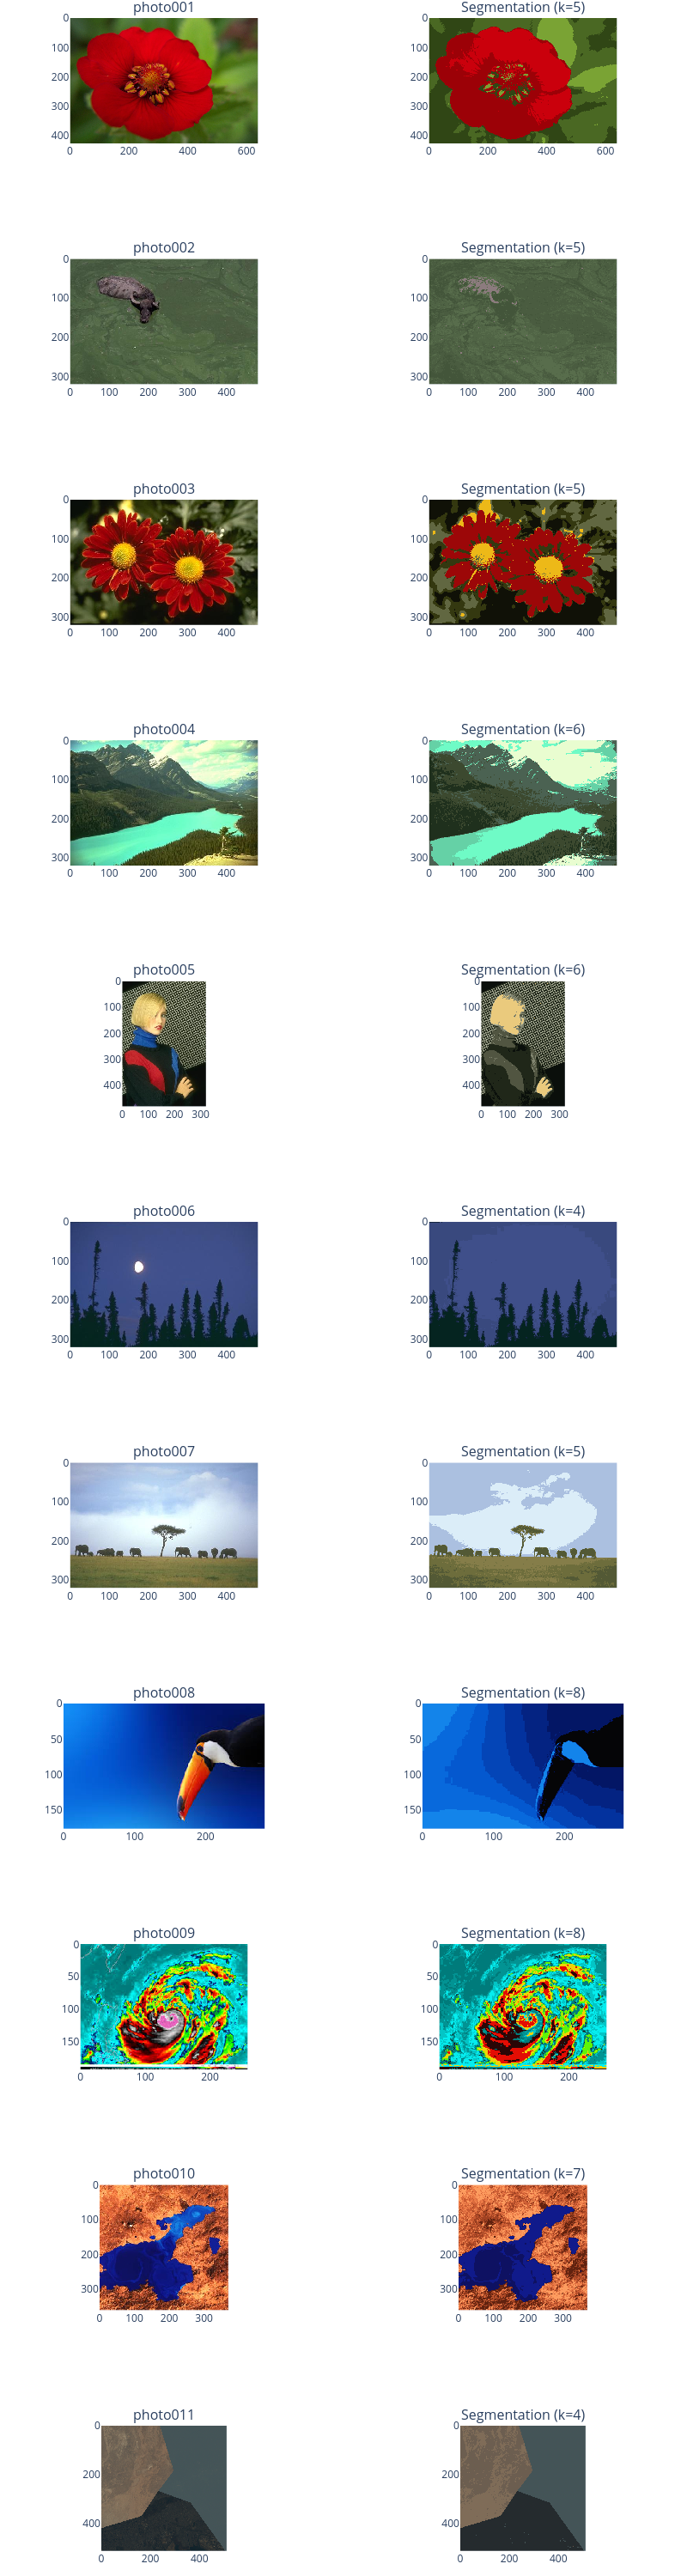

In [83]:
fig = image_segmentation([5, 5, 5, 6, 6, 4, 5, 8, 8, 7, 4])
fig.update_layout(margin={'t':20, 'b':20, 'r':20, 'l':20})
fig.show(renderer = 'png', width=800, height=3000)

# Referências
[1]  Jyh-Shing Roger Jang and Chuen-Tsai Sun. 1996. *Neuro-Fuzzy and Soft 
Computing: A Computational Approach to Learning and Machine Intelligence*. 
Prentice-Hall, Inc., Upper Saddle River, NJ, USA.